# システム解析論 レポート 1

29C23002 石川健太郎

In [ ]:
funcprot(0); // disable message on redefining a function

In [ ]:
[s, s_info] = loadwave('speech.wav');
Fₛ = s_info(3); // sampling rate
N = s_info(8); // number of samples
f = 1000; // frequency of the pure tone

In [ ]:
// f: frequency of the pure tone
// Fₛ: sampling rate
// N: number of samples
function a = pure_tone(f, Fₛ, N)
    a = cos(2 * %pi * f / Fₛ * [1:N]);
endfunction

In [ ]:
a = pure_tone(f, Fₛ, N);

In [ ]:
// x: input signal
// r: 0 < r < 1, determines bandwidth of notch filter
// μ: step size
function e = adaptive_notch_filter(x, r, μ)
    N = length(x);
    uₙ = 0; uₙ₋₁ = 0; uₙ₋₂ = 0; aₙ = 0;
    e = []; // output signal

    for n=1:N
        xₙ = x(n);
        uₙ = xₙ - aₙ * uₙ₋₁ - r * uₙ₋₂;
        yₙ = r * uₙ + aₙ * uₙ₋₁ + uₙ₋₂;
        eₙ = 0.5 * (xₙ + yₙ);
        aₙ = aₙ - μ * eₙ * uₙ₋₁;
        uₙ₋₂ = uₙ₋₁;
        uₙ₋₁ = uₙ;
        e = [e eₙ];
    end
endfunction

In [ ]:
// x: input signal
// ωᶜ: center frequency of notch filter
// r: 0 < r < 1, determines bandwidth of notch filter
function e = notch_filter(x, ωᶜ, r)
    N = length(x);
    a = -(1 + r) * cos(ωᶜ);
    uₙ = 0; uₙ₋₁ = 0; uₙ₋₂ = 0;
    e = []; // output signal

    for n=1:N
        xₙ = x(n);
        uₙ = xₙ - a * uₙ₋₁ - r * uₙ₋₂;
        yₙ = r * uₙ + a * uₙ₋₁ + uₙ₋₂;
        eₙ = 0.5 * (xₙ + yₙ);
        uₙ₋₂ = uₙ₋₁;
        uₙ₋₁ = uₙ ;
        e = [e eₙ];
    end
endfunction

## 実験

In [ ]:
x = s + 0.5 * a; // input signal

### $\mu = 0.1$ での適応ノッチフィルタ

入力の波形と周波数スペクトルは次の通り。

In [ ]:
wavwrite(x, Fₛ, 'input.wav');

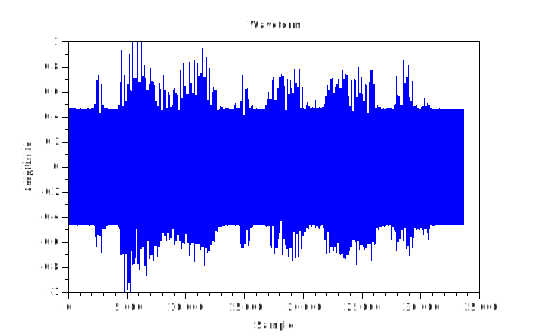

In [86]:
// thinning out points for vector file lightweighting
plot(1:10:N, x(1:10:$));
xtitle('Waveform', 'Sample', 'Amplitude');
gca().data_bounds = [1, -1; N, 1];

In [ ]:
spectrum = abs(fft(x));
frequencies = 1:N * Fₛ / N;

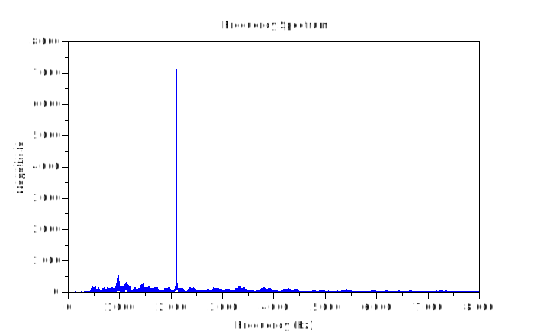

In [70]:
plot(frequencies(1:Fₛ/2), spectrum(1:Fₛ/2));
xtitle('Frequency Spectrum', 'Frequency (Hz)', 'Magnitude');

適応ノッチフィルタを適用する。

In [ ]:
e₁ = adaptive_notch_filter(x, 0.9, 0.1); // μ = 0.1

適応ノッチフィルタの出力の波形は次のようになる。

200 サンプル付近で振幅が発散してしまっている。

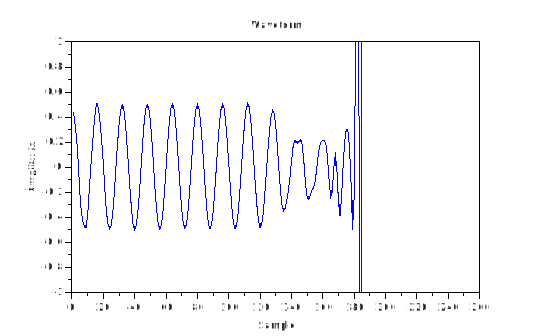

In [72]:
plot(1:N, e₁);
xtitle('Waveform', 'Sample', 'Amplitude');
gca().data_bounds = [1, -1; 250, 1];

In [ ]:
wavwrite(e₁, Fₛ, 'output_anf.wav');

### 周波数を既知とした場合のノッチフィルタ

純音の周波数を既知として、それを除去するノッチフィルタを適用する。

In [ ]:
ωᶜ = 2 * %pi * f / Fₛ; // angular frequency of the pure tone
e₂ = notch_filter(x, ωᶜ, 0.9);

ノッチフィルタの出力の波形と周波数スペクトルは次のようになる。

純音が除去されていることが周波数スペクトルから読み取れる。

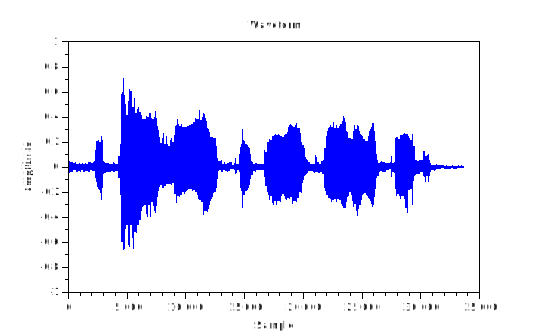

In [75]:
// thinning out points for vector file lightweighting
plot(1:5:N, e₂(1:5:N));
xtitle('Waveform', 'Sample', 'Amplitude');
gca().data_bounds = [1, -1; N, 1];

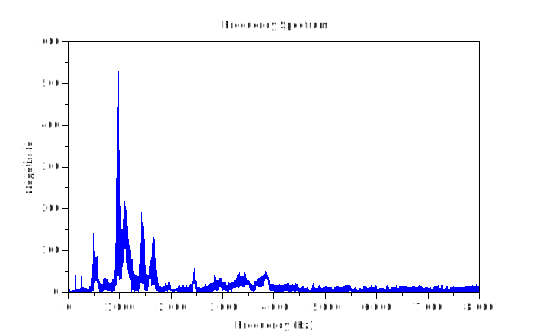

In [76]:
plot(frequencies(1:Fₛ/2), abs(fft(e₂))(1:Fₛ/2));
xtitle('Frequency Spectrum', 'Frequency (Hz)', 'Magnitude');

In [ ]:
wavwrite(e₂, Fₛ, 'output_nf.wav');

### $\mu = 0.001$ での適応ノッチフィルタ

ステップサイズを小さくして再び適応ノッチフィルタを適用する。

ノッチフィルタの出力の波形と周波数スペクトルは次のようになる。

波形から 13,000 サンプル付近から純音が除去されていることがわかる。

ただし、完全には除去できておらず、純音の影響が残っている。

In [ ]:
e₃ = adaptive_notch_filter(x, 0.9, 0.001); // μ = 0.001

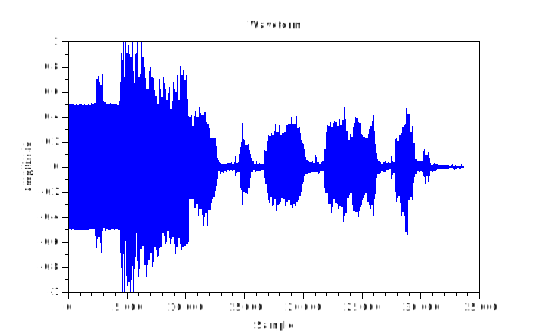

In [79]:
// thinning out points for vector file lightweighting
plot(1:5:N, e₃(1:5:N));
xtitle('Waveform', 'Sample', 'Amplitude');
gca().data_bounds = [1, -1; N, 1];

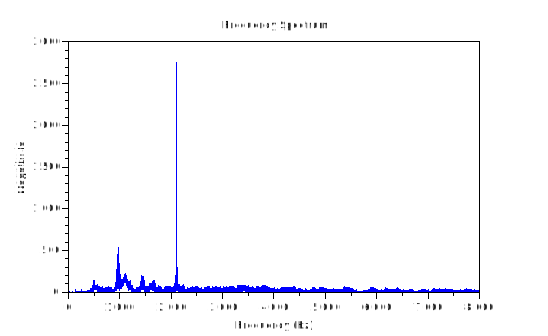

In [80]:
plot(frequencies(1:Fₛ/2), abs(fft(e₃))(1:Fₛ/2));
xtitle('Frequency Spectrum', 'Frequency (Hz)', 'Magnitude');

In [ ]:
wavwrite(e₃, Fₛ, 'output_anf_2.wav');

## 考察

$\mu = 0.1$ での適応ノッチフィルタの出力は振幅が発散していてうまく得られなかった。

周波数を既知としてノッチフィルタを適用すると、純音が完全に除去された。

$\mu = 0.001$ では純音の影響が残っていたが、もとの信号と比べると大幅に純音の影響を小さくできている。

以上から、もとの信号の特性に応じてステップサイズ $\mu$ を適切に設定することが適応ノッチフィルタによる純音の除去に必要であることがわかる。

以上の結果が、出力の音声ファイルと波形と周波数スペクトルから読み取れる。

## 添付ファイル

| ファイル名 | 内容 |
| --- | --- |
| input.wav | 入力信号 |
| output_anf.wav | 周波数未知の出力信号 |
| output_anf_2.wav | $\mu = 0.001$ としたときの周波数未知の出力信号 |
| output_nf.wav | 周波数既知の出力信号 |

## Scilab 実行環境

In [ ]:
[version, opts] = getversion();
COMPILER = opts(1);
ARCH = opts(2);
RELEASE_MODE = opts($-2);
RELEASE_DATE = opts($-1);
RELEASE_TIME = opts($);
VER_NUMS = getversion('scilab');

In [83]:
mprintf("COMPILER    : %s", COMPILER);
mprintf("ARCH        : %s", ARCH);
mprintf("RELEASE_MODE: %s", RELEASE_MODE);
mprintf("RELEASE_DATE: %s", RELEASE_DATE);
mprintf("RELEASE_TIME: %s", RELEASE_TIME);
mprintf("VERSION     : %d.%d.%d", VER_NUMS(1), VER_NUMS(2), VER_NUMS(3));

COMPILER    : GCC
ARCH        : x64
RELEASE_MODE: release
RELEASE_DATE: Nov 21 2020
RELEASE_TIME: 10:42:41
VERSION     : 6.1.0
